In [1]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
%matplotlib notebook

In [3]:
plt.rc('figure', figsize = [8,6]) # For interactive plots
# plt.rc('figure', figsize = [14,12]) # For static plots
plt.rc('axes',grid = True)

In [4]:
def extract_raw_RCS_TD_signal(input_json):
    d = {}
    temp = []    
    for j in range(0, len(input_json[0]['TimeDomainData'][0]['ChannelSamples'])):
        for i in range(0, len(input_json[0]['TimeDomainData'])):
            temp.extend(input_json[0]['TimeDomainData'][i]['ChannelSamples'][j]['Value'])
        d[j] = temp
        temp = []
    return d

def return_matching_x(processed_dict):
    d = {}
    for i, j in processed_dict.items():
        d[i] = np.arange(0, len(j), 1)
    return d

def prep_rcs_json_dict():
    d = {}
    for i in ['XSamples', 'YSamples', 'ZSamples']:
        d[i] = {}
        for j in ['sample_number', 'accel_data']:
            d[i][j] = []
    return d

def extract_raw_rcs_accel(accel_json):
    output_dict = prep_rcs_json_dict()
    
    for i in range(0, len(accel_json[0]['AccelData'])):
        for j in ['XSamples', 'YSamples', 'ZSamples']:
            output_dict[j]['accel_data'].extend(accel_json[0]['AccelData'][i][j])
            
    for i in ['XSamples', 'YSamples', 'ZSamples']:
        output_dict[i]['sample_number'] = np.arange(0,len(output_dict[i]['accel_data']),1)
        
    return output_dict

def convert_RCS_accel_json_to_df(rcs_json):
    rcs_df = pd.DataFrame({'sample_number' : rcs_json['XSamples']['sample_number'],
                       'XSamples' : rcs_json['XSamples']['accel_data'], 
                       'YSamples' : rcs_json['YSamples']['accel_data'], 
                       'ZSamples' : rcs_json['ZSamples']['accel_data']})
    return rcs_df

def normalize(vector):
    return ((vector - np.mean(vector)) / np.std(vector))

def series_by_col_applier(df,col_list,my_func):
    for i in col_list:
        df[i + '_' + my_func.__name__] = my_func(df[i])
    return df

def scrub_delsys_columns(delsys_df):
    delsys_df = delsys_df.loc[:,['X [s].1', 'IM: ACC X 1 (IM) [g]','IM: ACC Y 1 (IM) [g]','IM: ACC Z 1 (IM) [g]']]
    delsys_df = delsys_df.rename({x:y for x,y in zip(delsys_df.columns,['seconds','XSamples', 'YSamples', 'ZSamples'])}, axis=1)
    delsys_df = delsys_df[~np.isnan(delsys_df['seconds'])]
    return delsys_df

In [5]:
with open('./RawDataTD.json') as fd:
    raw_RCS_td = json.load(fd)

In [6]:
delsys = pd.read_csv('./2018-07-13 14-42 Delsys.csv')

In [7]:
delsys.head()

,X [s],func_gen_channel: EMG 1 [Volts]
0,0.000000,-0.005095
1,0.000519,-0.005095
2,0.001038,-0.005095
3,0.001558,-0.005095
4,0.002077,-0.004938


In [8]:
delsys.tail()

,X [s],func_gen_channel: EMG 1 [Volts]
425199,220.7764,0.0
425200,220.7769,0.0
425201,220.7774,0.0
425202,220.7780,0.0
425203,220.7785,0.0


In [9]:
delsys.columns

Index(['X [s]', 'func_gen_channel: EMG 1 [Volts]'], dtype='object')

In [10]:
filtered_delsys = delsys.rename({x:y for x, y in zip(delsys.columns, ['seconds', 'voltage'])},axis=1)
filtered_delsys.head()

,seconds,voltage
0,0.000000,-0.005095
1,0.000519,-0.005095
2,0.001038,-0.005095
3,0.001558,-0.005095
4,0.002077,-0.004938


#### Briefly Impute Delsys Sampling Rate

In [12]:
(filtered_delsys.iloc[-1,0] / filtered_delsys.shape[0])**-1

1925.9302875959388

<IPython.core.display.Javascript object>


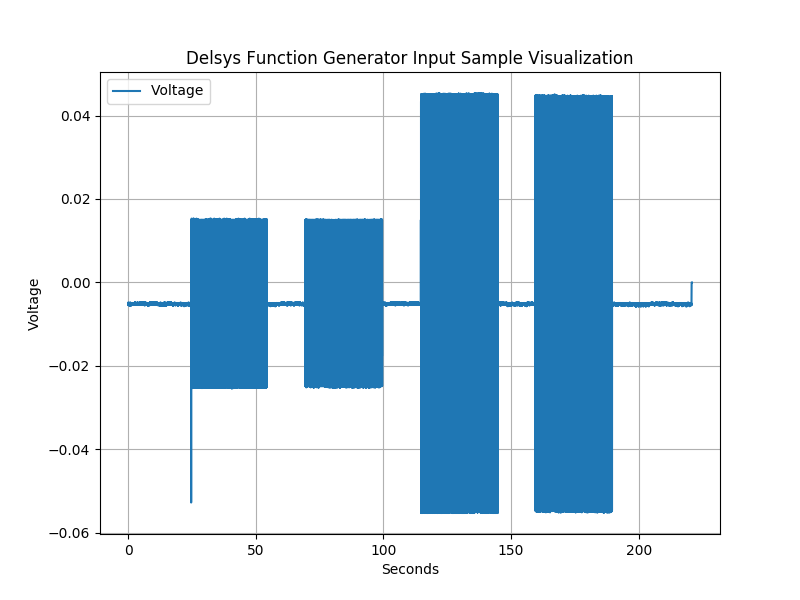

In [13]:
f1, ax = plt.subplots()

ax.plot(filtered_delsys.seconds,
       filtered_delsys['voltage'],
       label = 'Voltage')
ax.set(xlabel = 'Seconds', ylabel = 'Voltage')
ax.set_title('Delsys Function Generator Input Sample Visualization')
ax.legend()
# plt.savefig('./delsys_accel.png', dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


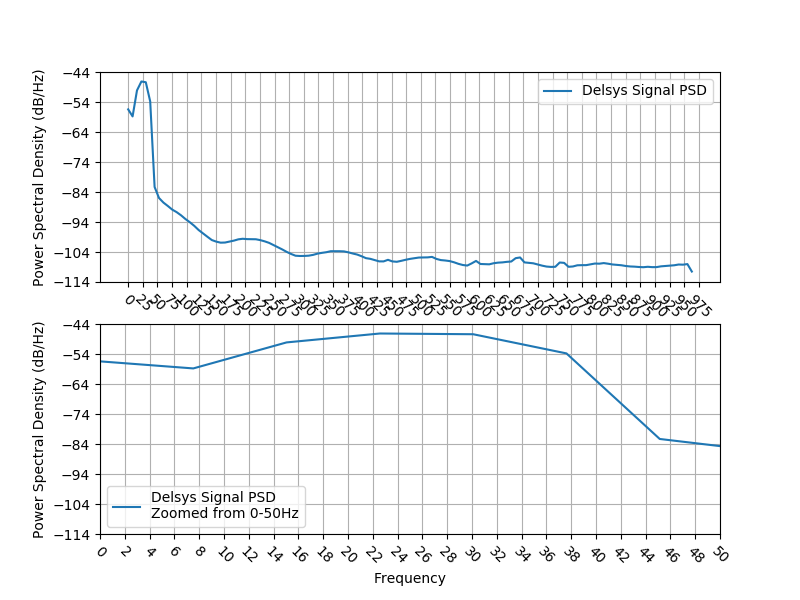

In [14]:
f2, ax = plt.subplots(nrows = 2)
ax[0].psd(filtered_delsys.voltage, Fs = 1926, label = 'Delsys Signal PSD')
ax[0].set(xticks = np.arange(0,1000,25))
ax[0].tick_params('x', rotation = 315)
ax[0].legend()
ax[1].psd(filtered_delsys.voltage, Fs = 1926, label = 'Delsys Signal PSD\nZoomed from 0-50Hz')
ax[1].set(xticks = np.arange(0,1000,2), xlim = (0,50))
ax[1].tick_params('x', rotation = 315)
ax[1].legend()
plt.show()

<IPython.core.display.Javascript object>


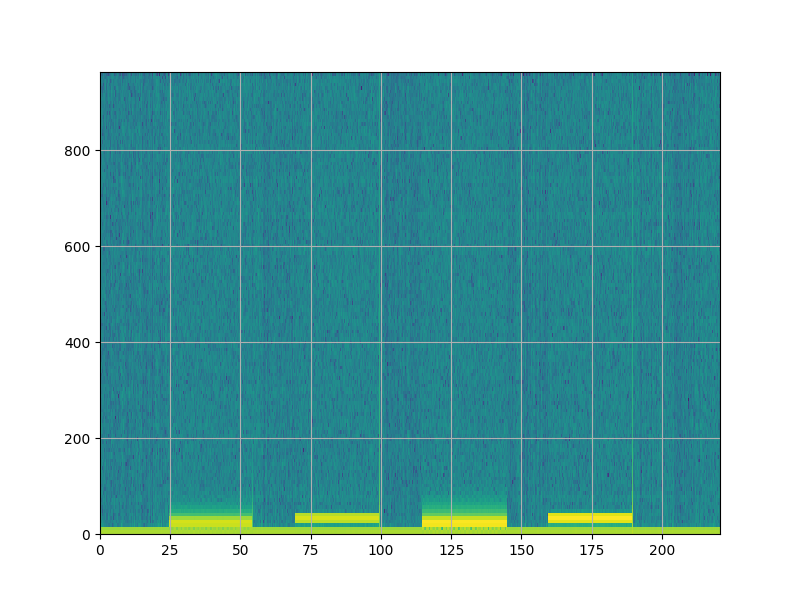

In [15]:
f3, ax = plt.subplots()
ax.specgram(filtered_delsys['voltage'], Fs=1926)
plt.show()

In [16]:
d1 = extract_raw_RCS_TD_signal(raw_RCS_td)

In [17]:
d2 = return_matching_x(d1)

In [18]:
len(d1[0])

195359

In [19]:
d1.keys()

dict_keys([0])

<IPython.core.display.Javascript object>


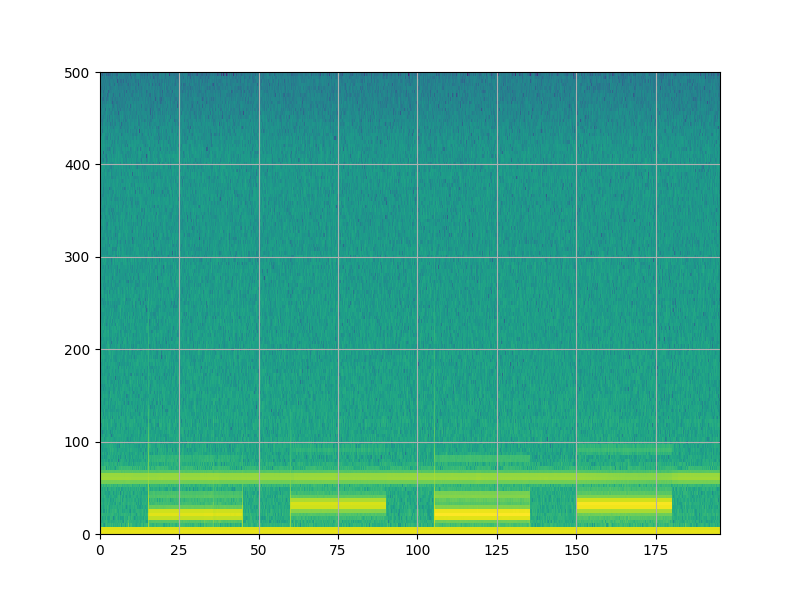

In [20]:
plt.figure()
plt.specgram(d1[0], Fs = 1000)
plt.show()

<IPython.core.display.Javascript object>


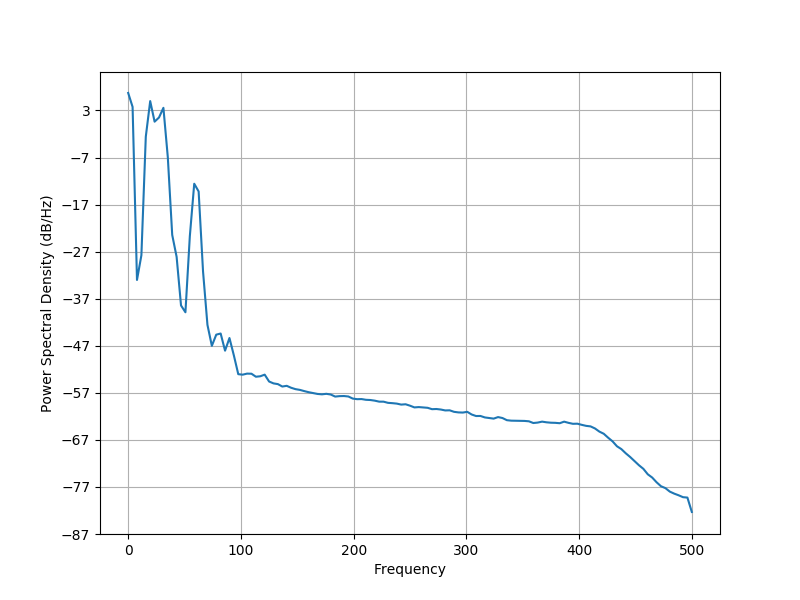

In [21]:
plt.figure()
plt.psd(d1[0], Fs = 1000)
# plt.xticks(np.arange(0,1000,2))
plt.show()

<IPython.core.display.Javascript object>


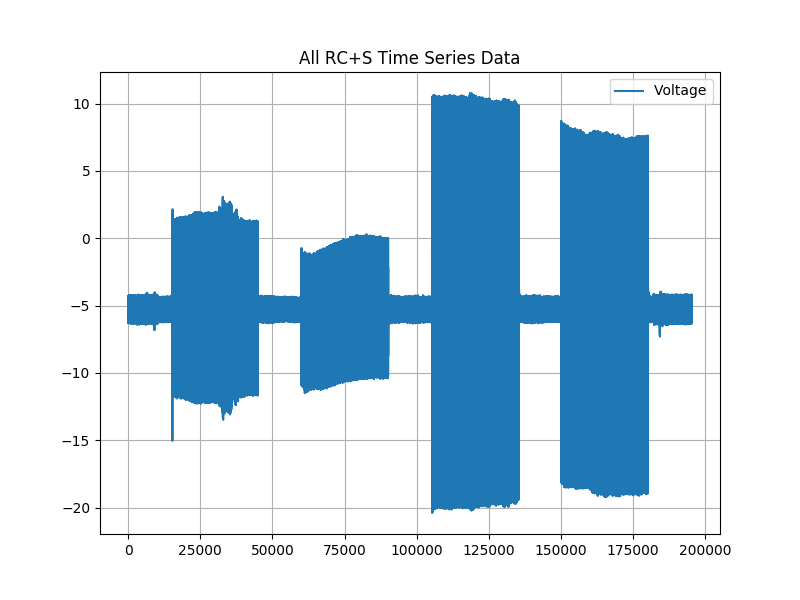

In [22]:
f4, ax = plt.subplots()
ax.plot(d2[0],
        d1[0],
        label = 'Voltage')
ax.legend()
ax.set_title('All RC+S Time Series Data')
plt.show()

# Normalize Delsys & RC+S Time Series Signals

#### Create Dataframe from RC+S Signal

In [23]:
rcs_df = pd.DataFrame({'sample_number' : d2[0],
                      'voltage' : d1[0]})
rcs_df.head()

,sample_number,voltage
0,0,-5.552405
1,1,-5.214116
2,2,-4.870236
3,3,-4.571089
4,4,-4.361406


In [24]:
rcs_df.tail()

,sample_number,voltage
195354,195354,-5.177771
195355,195355,-4.819912
195356,195356,-4.503990
195357,195357,-4.327856
195358,195358,-4.283124


In [25]:
rcs_df.shape

(195359, 2)

#### Run Normalization on Both RC+S and Delsys Data

In [26]:
rcs_df = series_by_col_applier(rcs_df, ['voltage'], normalize)

In [27]:
filtered_delsys = series_by_col_applier(filtered_delsys, ['voltage'], normalize)

In [28]:
filtered_delsys.head()

,seconds,voltage,voltage_normalize
0,0.000000,-0.005095,-0.000279
1,0.000519,-0.005095,-0.000279
2,0.001038,-0.005095,-0.000279
3,0.001558,-0.005095,-0.000279
4,0.002077,-0.004938,0.007638


In [29]:
rcs_df.head()

,sample_number,voltage,voltage_normalize
0,0,-5.552405,-0.049397
1,1,-5.214116,0.008140
2,2,-4.870236,0.066627
3,3,-4.571089,0.117505
4,4,-4.361406,0.153168


<IPython.core.display.Javascript object>


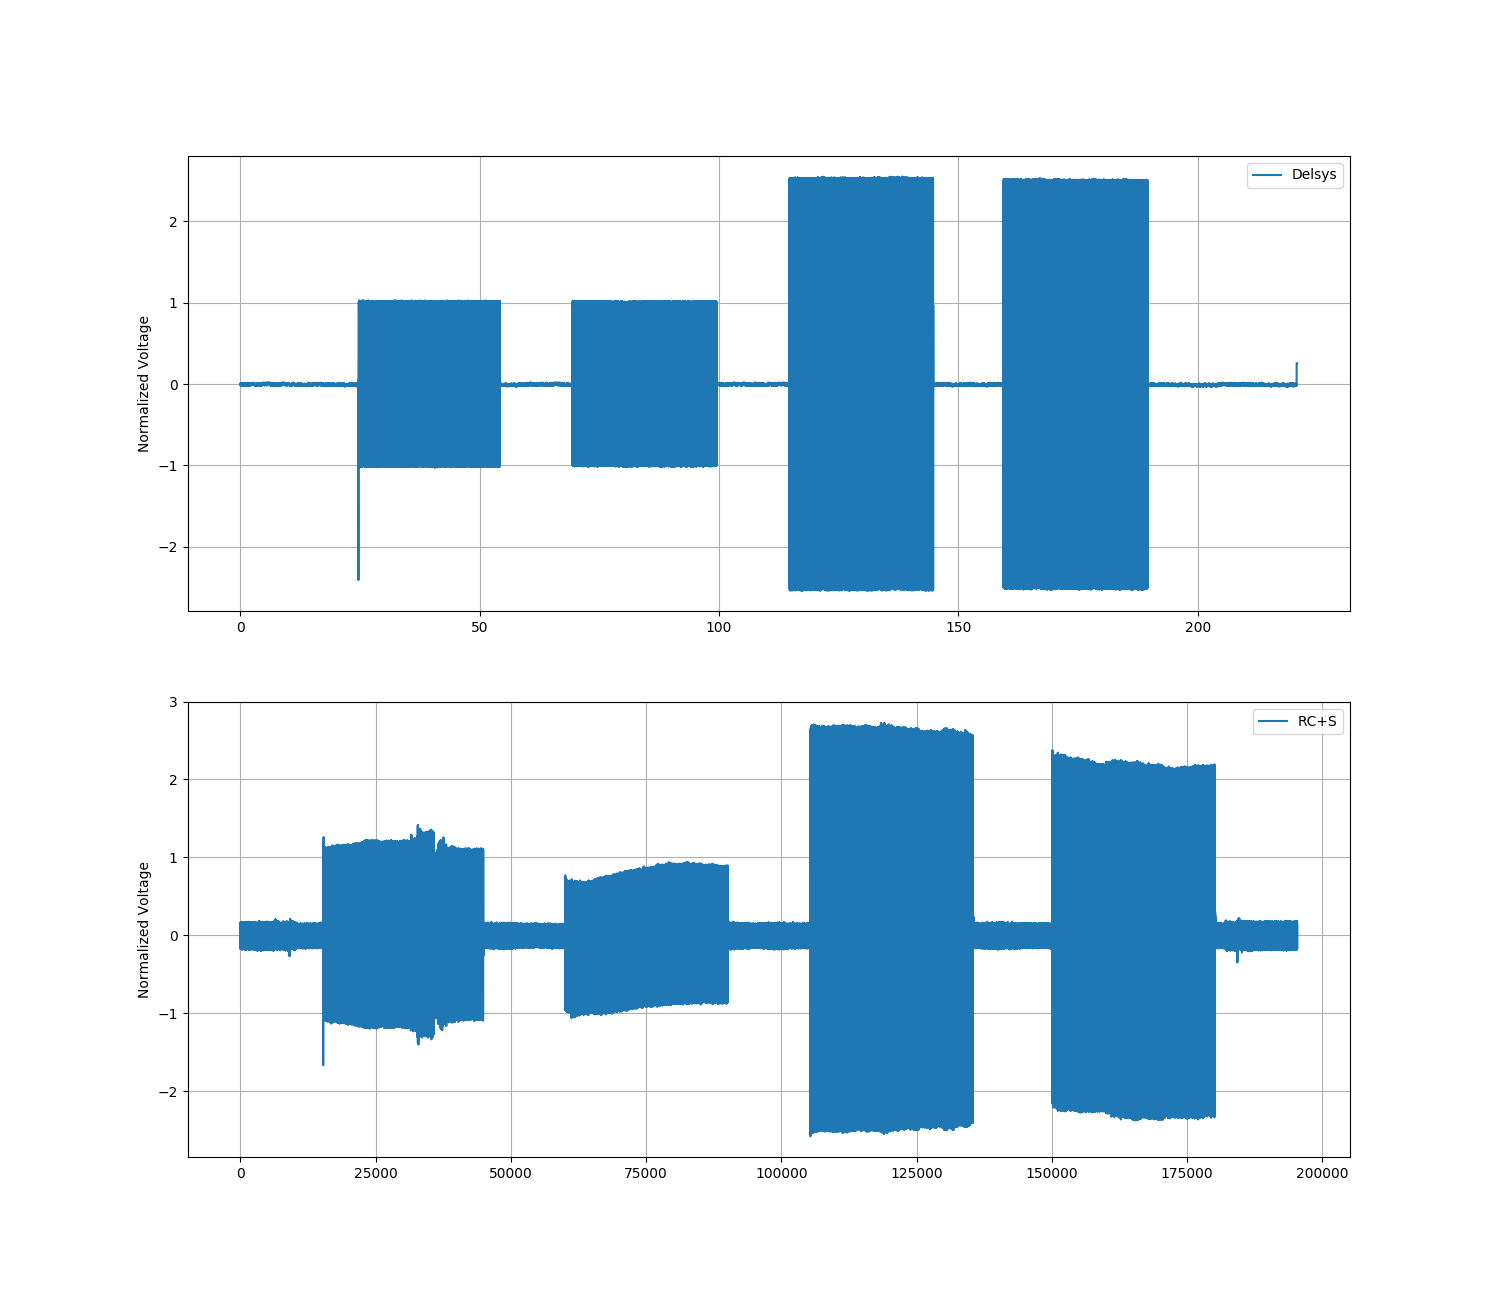

In [30]:
f5, ax = plt.subplots(nrows = 2, figsize = (15,13))
for a, d, t, l in zip(ax, [filtered_delsys, rcs_df],
               ['seconds','sample_number'],
                  ['Delsys','RC+S']):
    a.plot(d[t],
         d['voltage_normalize'],
         label = l)
    a.set(ylabel = 'Normalized Voltage')
    a.legend()
plt.show()

http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

# Crudely Normalize Time on the X-Axis of RC+S Data Assuming Sample Rate of 1000 Hz

Delsys recording already has time on the X-axis. Only the RC+S recording will be rescaled to be on actual time.

In [31]:
(rcs_df.sample_number.max()/1000)/60

3.2559666666666667

Looks like the RC+S Recording Time (shown above in mins) is Very Close to the Actual Recording Time on My iPhone's Stopwatch

In [32]:
rcs_df['normed_seconds'] = rcs_df.sample_number * (1/1000)

In [33]:
rcs_df.head()

,sample_number,voltage,voltage_normalize,normed_seconds
0,0,-5.552405,-0.049397,0.000
1,1,-5.214116,0.008140,0.001
2,2,-4.870236,0.066627,0.002
3,3,-4.571089,0.117505,0.003
4,4,-4.361406,0.153168,0.004


In [34]:
rcs_df.tail()

,sample_number,voltage,voltage_normalize,normed_seconds
195354,195354,-5.177771,0.014321,195.354
195355,195355,-4.819912,0.075186,195.355
195356,195356,-4.503990,0.128918,195.356
195357,195357,-4.327856,0.158875,195.357
195358,195358,-4.283124,0.166483,195.358


In [35]:
rcs_df.tail()

,sample_number,voltage,voltage_normalize,normed_seconds
195354,195354,-5.177771,0.014321,195.354
195355,195355,-4.819912,0.075186,195.355
195356,195356,-4.503990,0.128918,195.356
195357,195357,-4.327856,0.158875,195.357
195358,195358,-4.283124,0.166483,195.358


#### Repeat the Above Plot Now that the RC+S Data Has Been Rescaled

<IPython.core.display.Javascript object>


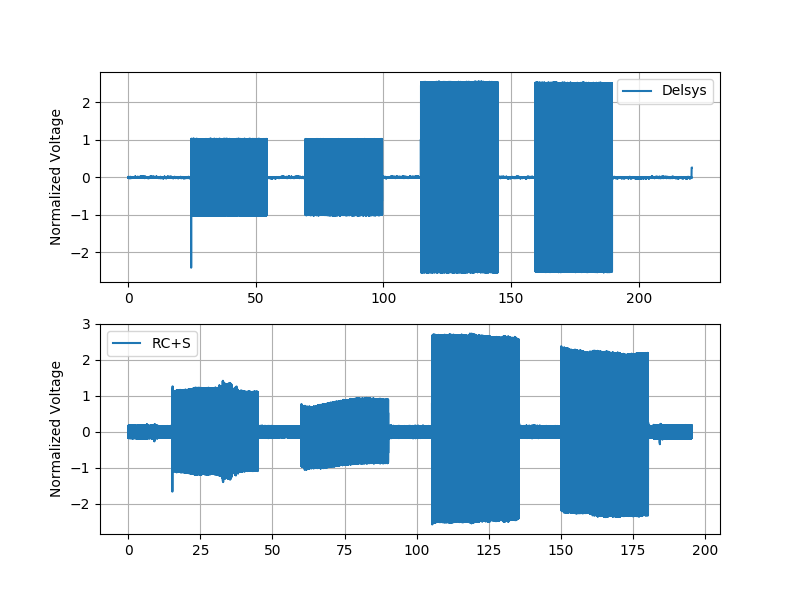

In [36]:
f6, ax = plt.subplots(nrows = 2)
for a, d, t, l in zip(ax, [filtered_delsys, rcs_df],
               ['seconds','normed_seconds'],
                  ['Delsys','RC+S']):
    a.plot(d[t],
         d['voltage_normalize'],
         label = l)
    a.set(ylabel = 'Normalized Voltage')
    a.legend()
plt.show()

<IPython.core.display.Javascript object>


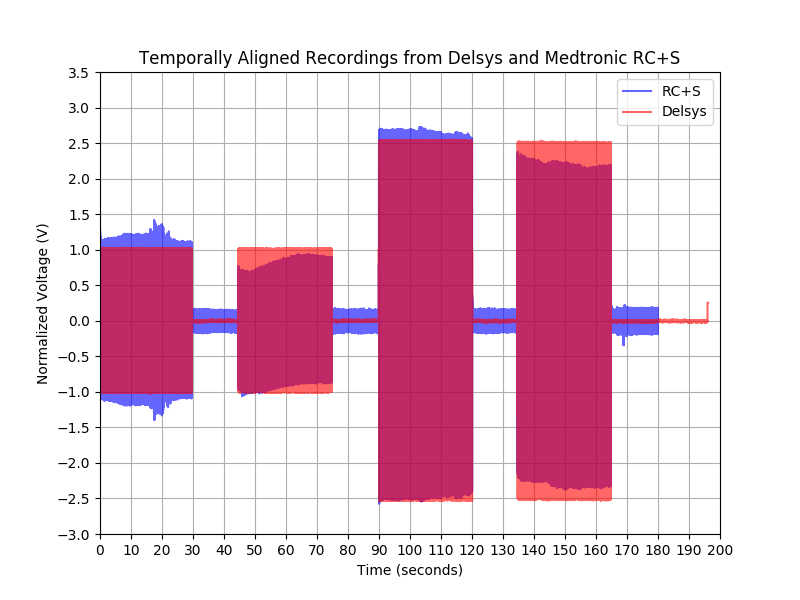

In [56]:
f7, ax = plt.subplots()

ax.plot((rcs_df.normed_seconds - 15.3569), rcs_df.voltage_normalize,'b', alpha=.6, label = 'RC+S')
ax.plot((filtered_delsys.seconds - 24.7087), filtered_delsys.voltage_normalize, 'r', alpha = .6, label = 'Delsys')
ax.set(xlim = (0,200), 
       xticks = np.arange(0,210,10), 
       yticks = np.arange(-3,4,.5),
      xlabel = 'Time (seconds)',
      ylabel = 'Normalized Voltage (V)',
      title = 'Temporally Aligned Recordings from Delsys and Medtronic RC+S')
ax.legend()
plt.show()

# Peak Detection

In [ ]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

# from __future__ import division, print_function
# import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data points???).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
#     try:
#         import matplotlib.pyplot as plt
#     except ImportError:
#         print('matplotlib is not available.')
#     else:
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 10))

    ax.plot(x, 'b', lw=1)
    if ind.size:
        label = 'valley' if valley else 'peak'
        label = label + 's' if ind.size > 1 else label
        ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (ind.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    mode = 'Valley detection' if valley else 'Peak detection'
    ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                 % (mode, str(mph), mpd, str(threshold), edge))
    plt.grid()
    plt.show()

In [ ]:
rcs_peaks = detect_peaks(rcs_df_normed.XSamples,mph=5,mpd = 50,show=True)

In [ ]:
delsys_peaks = detect_peaks(delsys_normed.XSamples_normalize, mph = 5, mpd = 1000, show=True)

In [ ]:
delsys_peaks

In [ ]:
rcs_peaks

#### Let's align on data point 622 for Delsys and 1277 for RCS

First we get the times at which these peaks occured in each stream

In [ ]:
rcs_df_normed.iloc[rcs_peaks[0],:]

In [ ]:
delsys_normed.iloc[delsys_peaks[0],]

#### I will now rescale the time on both streams such that the IDed peaks become t = 0

In [ ]:
rcs_df_normed.iloc[rcs_peaks[0],7]

In [ ]:
delsys_normed.iloc[delsys_peaks[0],0]

In [ ]:
rcs_df_normed['time_shift'] = rcs_df_normed.normed_seconds - rcs_df_normed.iloc[rcs_peaks[0],7]

In [ ]:
rcs_df_normed.head()

In [ ]:
rcs_df_normed[(rcs_df_normed.time_shift >= 0) & (rcs_df_normed.time_shift <= 1)]

In [ ]:
delsys_normed['time_shift'] = delsys_normed.seconds - delsys_normed.iloc[delsys_peaks[0],0]

In [ ]:
delsys_normed.head()

In [ ]:
delsys_normed[(delsys_normed.time_shift >= 0) & (delsys_normed.time_shift <= 1)]

#### Make plot of just the x-axis samples to compare alignment/drift

In [ ]:
f11, ax = plt.subplots()

for d in [delsys_normed, rcs_df_normed]:
    ax.plot(d['time_shift'][d['time_shift'] >= 0],
           d['XSamples_normalize'][d['time_shift'] >= 0])
    ax.set(yticks = np.arange(-30,35,5),
          xticks = np.arange(0, 950, 30))
    ax.tick_params(axis='x',rotation = 315)

plt.show()

# Try to Manually Align Traces

In [ ]:
delsys_normed.columns

In [ ]:
rcs_df_normed.columns

In [ ]:
f12, ax = plt.subplots()
ax.plot(delsys_normed.seconds,
       delsys_normed.XSamples_normalize,
       label = 'Delsys')
ax.plot((rcs_df_normed.sample_number * (1/32)) - 41.83,
       rcs_df_normed.XSamples_normalize,
       label = 'RC+S')
ax.set(xlabel = 'Time (seconds)', 
       ylabel = 'Normalized Acceleration',
      xticks = np.arange(0,901,2),
      xlim = (0,905))
ax.tick_params(axis='x', rotation = 315)
ax.legend()
plt.suptitle('Plot of RC+S/Delsys Accelerometry vs. Time')
plt.show()